# **Trabajo final de Aprendizaje Máquina I**

## Señales de audio

**Rubén Balbastre Alcocer**

**Agustín Matías Galante Cerviño**

**24/01/2022**

# Índice

* Introducción
* I. Técnicas de aprendizaje no supervisado
* II. Técnicas de aprendizaje supervisado
* III. Ranking de características y métodos ensembles
* IV. Conclusiones

# Introducción

Este documento contiene el trabajo final de la asignatura Aprendizaje Máquina I. El objetivo
principal es la clasificación de un conjunto de señales de audio agrupadas en 6 clases. Más concretamente, en el análisis de la de selección, entrenamiento y validación de los modelos. Para ello se
dispone de un conjunto etiquetado y otro no etiquetado. El trabajo se divide en cuatro grandes
partes. La primera comtempla la transformación de los datos y su estudio mediante técnicas de
aprendizaje no supervisado. La segunda, técnicas de aprendizaje supervisado para su clasificación.
La tercera contempla técnicas de "ranking" de características así como técnicas de *ensemble* que intentan mejorar los resultados anteriores. Por
último, se ofrece una perspectiva general de los resultados obtenidos y se selecciona el mejor
método presentando las conclusiones sobre los datos no etiquetados.

Con el fin de asegurar una correcta ejecución del notebook se recomienda asegurar la instalación de
las siguientes librerías en las versiones mencionadas. Es posible que la versión indicada no sea la
única que funcione correctamente pero para asegurarnos la repetibilidad de los resultados así lo
hacemos.

* scikit-learn, versión 0.24.2
* numpy, versión 1.20.3
* matplotlib, versión 3.4.3
* pandas, versión 1.3.4
* librosa, versión 0.8.1
* copy, versión 3.10.2
* IPython, versión 7.29

También es necesario tener el archivo `punto1.py` donde están descritas algunas de las funciones que
utilizaremos para la importación y transformación de datos. Las funciones y librerías que se utilizan ahí son las mismas que se han especificado ya.

In [1]:
# Librerías y funciones necesarias
import punto1 as p1 
import numpy as np
import pandas as pd
from IPython.display import display
# Aprendizaje no supervisado
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from copy import deepcopy
# Aprendizaje supervisado
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
# Modelos usados para realizar rankings
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
# Ensembles clasificadores
from sklearn.utils import resample
from scipy.stats import mode
from sklearn.metrics import classification_report as report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# Representaciones gráficas
import matplotlib.pyplot as plt
# Fijamos una única semilla para la repetibilidad de los resultados
seed = 123 

# I. Técnicas de aprendizaje no supervisado

## I.I Clustering de datos sin considerar etiquetas

> Usar algún algoritmo de clustering sobre todos los datos sin emplear las etiquetas para obtener un
> primer análisis de los datos. El objetivo consiste en descubrir posibles patrones en los datos y
> hasta qué punto estos son compatibles con las etiquetas.

Con el objetivo de maximizar el conocimiento de nuestro conjunto de datos, dividiremos este
primer apartado en dos. El primero de ellos trata los datos etiquetados en el fichero `adata5.npy` y
el segundo, estos más el conjunto de datos no etiquetados `udata.npy`. También se trata la
importación y procesado de datos. No obstante, enunciemos las líneas generales que se seguirán en
ambos apartados.

#### Importado y preprocesado de datos

Con una frecuencia de muestreo de 22 050 Hz y con 3 segundos, tenemos 66 150 muestras, lo cual no
permite un entrenamiento adecuado teniendo en cuenta que solo tenemos 720 muestras etiquetadas pues no
vamos a ser capaces de cubrir todo el espacio n-dimensional lo suficientemente bien como para poder
generalizar a nuevas muestras. Para reducir la dimensionalidad del problema, usaremos una función
expresamente hecha para este trabajo, contenida en el archivo
`punto1.py`. Esta función se encarga de dos tareas:

* Transformación del dominio temporal al dominio de los coeficientes cepstrales de las frecuencias
  de Mel (MFCC). Utilizamos la función `mfcc` del módulo `feature` de la librería `librosa`.
* Obtención de las componentes principales de la matriz de datos. Hacemos uso de la función `PCA`
  del módulo `decomposition` de la librería `scikit-learn`.

Para más detalles sobre la implementación, visualícese el archivo `punto1.py` donde está
implementada la función `importar_y_transformar_datos` para los datos etiquetados e
`importar_y_transformar_TODOS_datos` para el conjunto de los etiquetados y los no etiquetados. Decidimos
no estandarizar los datos antes de pasar al dominio de MCFCC pues para señales de audio no
tiene sentido equivarianza de los atributos además de que los resultados eran mucho peores. Respecto a los parámetros elegidos para estas
funciones, ambas toman los siguientes valores:

Generamos 128 bandas de Mel (valor por defecto en la función `mfcc`) y seleccionamos 10
coeficientes (argumento `n_mfcc=10`). Para la transformación PCA seleccionamos los vectores propios que explican un 99% de la varianza de los datos. Probamos la posibilidad de modificar el parámetro `lifter` de la función
`mfcc` para filtrar los coeficientes pero los resultados del test tanto de las técnicas supervisadas
como las de *ensemble* empeoraban notablemente así que lo descartamos. Las funciones devuelven el
conjunto de datos original `data`, el conjunto de datos transformado `X` y sus etiquetas `labs`
(sólo para `importar_y_transformar_datos`).

También se incluye la función `import_y_transformar_datos_no_etiquetados` en el archivo `punto1.py`
cuyo funcionamiento se explicará en la correspondiente sección (IV. Conclusiones).

#### Técnicas no supervisadas: clustering

Para seleccionar un método de clustering apropiado para el conjunto que incluye a las muestras no
etiquetadas, realizaremos un análisis previo de los datos que tenemos etiquetados. Con ello,
podremos ver qué clases están más cerca unas de otras. Los algoritmos que utilizaremos son: c-means
y algunos pertenecientes a las categorías de *spectral clustering* y *agglomerative clustering*. Con ello, esperamos un cubrir un rango de variedad de algoritmos que permita analizar bien los datos independientemente de su distribución n-dimensional. También probamos otro tipo de algoritmos como los de lógica difusiva. Más concretamente, la
implementación `cmeans` de la librería `skfuzzy` no aportaba nueva información por lo que decidimos
no incluir sus resultados en el trabajo. Utilizaremos las implementaciones de `scikit-learn`:
`KMeans`, `SpectralClustering`, `AgglomerativeClustering` y `GaussianMixture`. Estos métodos de
clustering también se utilizarán para el segundo apartado.

#### Criterios de evaluación

Para evaluar la calidad de nuestros *clusters* en los datos etiquetados utilizaremos varios índices:
*Adjusted Rand (AR)*, *Mutual Information (MI)*, *Homogenity* , *Completeness*, *V-measure*,
Fowlkes-Mallows (FMI), *Silhouettes* y Calinski-Harabasz. Para representarlos utilizamos dos
funciones desarrolladas en el archivo `punto1.py`. La función `siluetas_test` calcula los
índices anteriores y la función `curvas_diagnostico` los representa en una misma figura. Decidimos no incluir
otros índices vistos en clase como *Adjusted Mutual Information* y *Normalize Mutual Information*
porque daban la misma información que *V-Measure* en todos los casos. 

El coeficiente de silueta (*Silhouettes*) se define como: $s = \frac{b - a}{max(a, b)}$ donde $a$
es la distancia media entre una muestra y todas las de su misma clase, $b$ es la distancia media
entre una muestra y el resto de puntos del siguiente cluster. Por tanto, *clusters* con siluetas
negativas indican que no están bien definidos pues la distancia entre los puntos del próximo cluster
es mayor que la de los mismo puntos del cluster. Al contrario, un índice de silueta próximo a la
unidad indica que los *clusters* están bien definidos pues $a << b$. Tomamos coeficiente de silueta para n *clusters* el valor medio del coeficiente de silueta de todos los grupos.

El índice de Calinski-Harabasz también indica grupos mejor definidos conforme se acerca a la
unidad. Para el resto de índices utilizados en las figuras, la tendencia es idéntica: 1 indica que
las etiquetas son idénticas y 0 que son totalmente aleatorias en comparación. 

Para la evaluación del conjunto de datos total únicamente utilizaremos los índices de silueta y
Calinski-Harabasz. En el caso del algoritmo c-means incluiremos el criterio "del codo" de la curva
de inercia que se explicará más detalladamente en la sección correspondiente.

In [2]:
# importación y transformación de los datos etiquetados
data, X, labs = p1.importar_y_transformar_datos(n_mfcc = 10, n_mels = 128, n_components = 0.99, verbose = 1)



Dimensiones originales 66150, dimensiones tras transformación 354


### I.I.I Clustering de datos etiquetados
Expliquemos brevemente las funciones utilizadas para los clusterings y mostremos sus resultados en
una figura para poder realizar un buen análisis. Realizamos una serie de clustering para diferentes
valores del número de *clusters* (desde 2 hasta 12) para todos los casos. El valor mínimo es 2, necesario para poder analizar los índices, y el valor máximo es 12. Dado que es el doble que el número de clases reales consideramos que es más que necesario para ver el comportamiento de estos. Además, lo comprobamos por lo que mostramos desde 2 hasta 12 *clusters*.

#### C-Means
El algoritmo *c-means* se caracteriza por ser rápido e intuitivo. Es un algoritmo basado en
centroides. Su función de penalización J se define como: $J = \sum_i^c \sum_{x\in X_i} |x - m_i|^2 $
donde $m_i$ representa el centroide de cada grupo. Generalmente, este algoritmo funciona bien
siempre que las distribuciones de los grupos (*clusters*) no se desvíen mucho de una hiperesfera. Este
permite utilizar el criterio del codo de inercia antes comentado. La inercia en una distancia
intra-cluster definida especialmente en este algoritmo con el método `.inertia_`. Este nos indica que el número óptimo
de cluster se encuentra donde la curva empieza a decrecer más suavemente de manera que visualmente
parece un codo. Podemos normalizarlo e incluirlo junto con los otros índices. Utilizamos los
parámetros por defecto de la función `KMeans` de la librería `scikit-learn`.

#### Spectral Clustering
El clustering espectral resulta muy útil problemas donde la estructura de *clusters* es especialmente
no convexa, o más generalmente cuando la medida entre el centro de un cluster y sus componentes no
es susceptible de describir adecuadamente el cluster como sucede en *clusters* concéntricos en
círculos en un plano bidimensional. Calculamos la matrix de afinidad mediante `affinity =
'nearest_neighbors'` porque con la opción de defecto `'rbf'` devuelve un aviso indicando que el
grafo no está plenamente conectado y los resultados pueden no ser los esperados.

#### Agglomerative Clustering
Este método agrupa las muestras por pares de acuerdo a su distancia de enlace. Utilizamos el
criterio por defecto `linkage=ward` que minimiza la varianza de los *clusters* unidos.

#### Gaussian Mixture
Esta función utiliza una mezcla de distribuciones gaussianas para la distribución de los datos. Esta
función implementa el algoritmo EM para estimar los valores de cada gaussiana. Seleccionamos el
parámetro por defecto `covariance_type='full'` pues es el tipo de covarianza más general y no
tenemos ningún conocimiento como deben de ser.

<AxesSubplot:title={'center':'Gaussian mixture'}, xlabel='Número de clusters', ylabel='Otras medidas'>

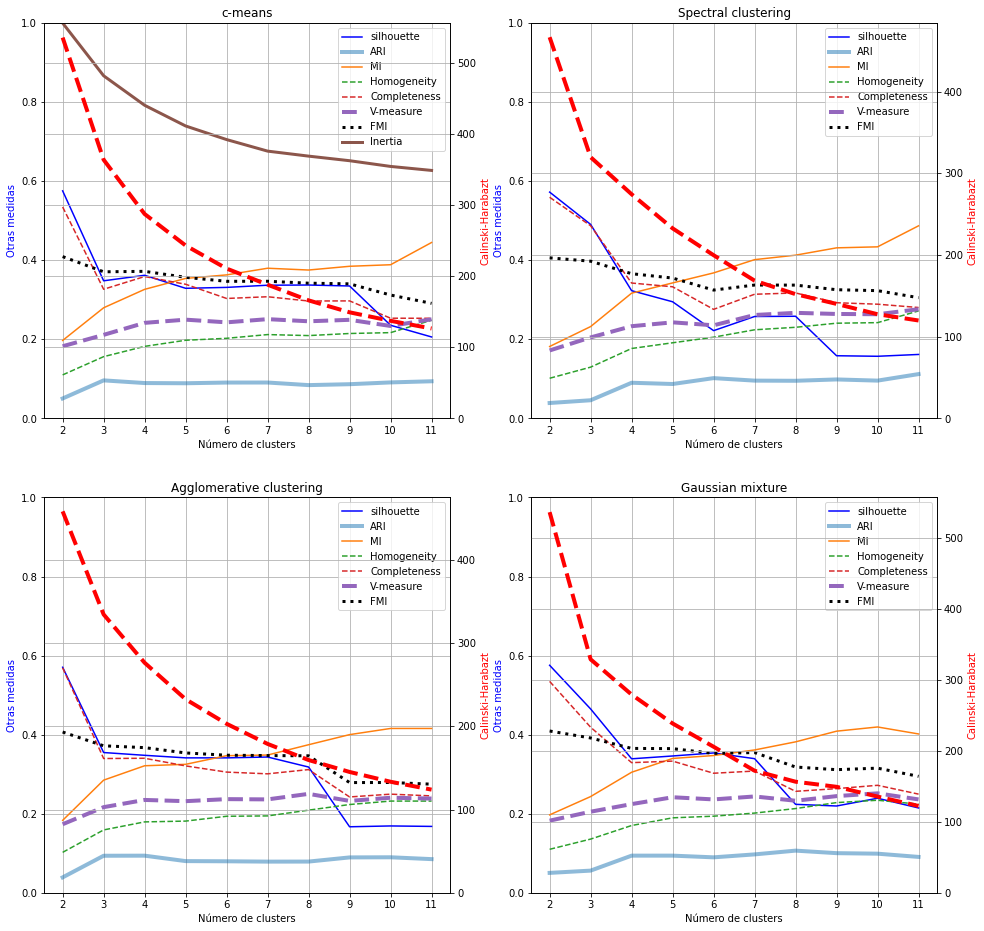

In [3]:
fig = plt.figure(figsize = (16, 16))

############## c-means

ax0 = fig.add_subplot(2,2,1)

# Entrenamiento y predicción
range_clusters = np.arange(2,12)
labs_pred = []
inertia = []
for i in range_clusters:
    clusterer = KMeans(n_clusters = i, random_state = seed)
    labs_pred.append(clusterer.fit_predict(X,labs))
    inertia.append(clusterer.inertia_)

# Criterios de evaluación
silh_valores = p1.siluetas_test(X = X, y = labs, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 1)
ax = p1.curvas_diagnostico(silh_valores, comparation_true_labels = 1, legend = 0, title = "c-means", ax1 = ax0)
# Inercia
inertia = inertia / np.max(inertia)
ax.plot(range_clusters, inertia, label = "Inertia", lw = 3)
ax.legend(loc = "upper right")

############## SpectralClustering

ax1 = fig.add_subplot(2,2,2)

# entrenamiento y predicción
labs_pred = []
for i in range_clusters:
    clusterer = SpectralClustering(n_clusters = i, random_state = seed, affinity = 'nearest_neighbors')
    labs_pred.append(clusterer.fit_predict(X))

# criterios de evaluación
silh_valores = p1.siluetas_test(X = X, y = labs, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 1)
p1.curvas_diagnostico(silh_valores, comparation_true_labels = 1, legend = 1, title = 'Spectral clustering', ax1 = ax1)

############## Agglomerative Clustering

ax2 = fig.add_subplot(2, 2, 3)

# entrenamiento y predicción
labs_pred = []
for i in range_clusters:
    clusterer = AgglomerativeClustering(n_clusters = i, distance_threshold = None)
    labs_pred.append(clusterer.fit_predict(X))

# criterios de evaluación
silh_valores = p1.siluetas_test(X = X, y = labs, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 1)
p1.curvas_diagnostico(silh_valores, comparation_true_labels = 1, legend = 1, title = 'Agglomerative clustering', ax1 = ax2)

############## Gaussian Mixture

ax3 = fig.add_subplot(2,2,4)

# entrenamiento y predicción
labs_pred = []
for i in range_clusters:
    clusterer = GaussianMixture(n_components = i, random_state = seed)
    labs_pred.append(clusterer.fit_predict(X))

# criterios de evaluación
silh_valores = p1.siluetas_test(X = X, y = labs, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 1)
p1.curvas_diagnostico(silh_valores, comparation_true_labels = 1, legend = 1, title = 'Gaussian mixture', ax1 = ax3)

Comentemos los resultados obtenidos más destacables:

El coeficiente de siluetas y la completitud decrecen bruscamente de 2 a 3 grupos en todas las curvas para todos los métodos. Esto nos indica que la mejor clasificación se efectúa para 2 *clusters*. Sin embargo, también exhiben un descenso muy suave hasta 7 *clusters* aproximadamente para luego volver a descender bruscamente (a excepción de `SpectralClustering` donde el descenso es más escalonado). Por otro lado, si atendemos a otros índices como la *V-measure* y la homogeneidad podemos encontrar un ascenso hasta 6 o 7 *clusters* aproximadamente a partir de los cuales suaviza. El criterio del codo de inercia de c-means no muestra un claro candidato aunque podría aceptarse 7.  Por tanto, encontramos un gran clustering de 2 grupos que a su vez de puede profundizar en hasta 7 aproximadamente.

Conozcamos cuáles son las clases verdaderas que han sido clasificadas en cada uno de los 2 *clusters* de primera aproximación. Las etiquetas de nuestros audios son: `['Door knock', 'Mouse click', 'Keyboard typing', 'Door, wood creaks', 'Can opening','Washing machine']`. Por completitud, mostremos también como se distribuyen las etiquetas para 4 y 7 *clusters* también. Utilicemos `KMeans` para evaluar esta distribución.

In [4]:
def conocer_clasificacion_segun_etiqueta(n = 2):
    km = KMeans(n_clusters = n, random_state = seed)
    labs_pred = km.fit_predict(X)
    names = ['Door knock', 'Mouse click', 'Keyboard typing', 'Door, wood creaks', 'Can opening', 'Washing machine']

    reparto = {i:{nam:0 for nam in names} for i in range(n)}

    # por cada elemento de los datos etiquetados
    for element in range(X.shape[0]):
        inf = 0
        sup = 120
        # por cada etiqueta posible del clustering
        for k in names: 
            # se encuentra en la clase i... 
            if element < sup and element > inf:
                for kk in range(n):
                    if labs_pred[element] == kk:
                        reparto[kk][k] +=  1
            inf += 120 
            sup += 120

    return display(pd.DataFrame(reparto))

conocer_clasificacion_segun_etiqueta(n = 2)
conocer_clasificacion_segun_etiqueta(n = 4)
conocer_clasificacion_segun_etiqueta(n = 7)

,0,1
Door knock,113,6
Mouse click,119,0
Keyboard typing,119,0
"Door, wood creaks",114,5
Can opening,119,0
Washing machine,43,76


,0,1,2,3
Door knock,82,3,34,0
Mouse click,113,0,6,0
Keyboard typing,101,0,18,0
"Door, wood creaks",73,0,20,26
Can opening,116,0,3,0
Washing machine,12,61,40,6


,0,1,2,3,4,5,6
Door knock,25,66,1,22,5,0,0
Mouse click,3,110,0,6,0,0,0
Keyboard typing,1,95,0,16,0,7,0
"Door, wood creaks",7,66,0,16,0,25,5
Can opening,2,113,0,2,0,2,0
Washing machine,3,9,36,34,31,0,6


Respecto del clustering de 2 grupos:

Prácticamente todas las etiquetas se agrupan en el clustering 0 a excepción de *Washing machine* que está repartida un 30-70 % aproximadamente. Es obvio que para el oído humano este sonido es ligeramente diferente a las otras 5 clases por lo que los resultados entran dentro de lo que esperábamos.

Respecto del clustering de 4 grupos:

*Keyboard typing*, *Keyboard Typing* y *Can opening* están prácticamente en la misma clase pues el número de elementos 0 es un 80% del total (~ 100/120), mientras que las otras comienzan a repartirse más entre clases.

Respecto del clustering de 7 grupos:

Encontramos un cluster mucho más grande que los demás (grupo 1) que contiene a la mayoría de las etiquetas a excepción de *Washing Machine*.

Con todo ello, se concluye que la mejor agrupación de los datos proporcionada por los algoritmos de aprendizaje no supervisado es: *Washing machine* y *otros*.

### I.I.II Clustering de todos los datos

Realicemos un estudio análogo al anterior pero ahora para el conjunto de todos los datos: etiquetados y no etiquetados.

In [5]:
# importación y transformación de los datos
data, X = p1.importar_y_transformar_TODOS_datos(n_mfcc = 10, n_mels = 128, n_components = 0.99, verbose = 1)



Dimensiones originales 66150, dimensiones tras transformación 367


Presentamos una figura similar a la del apartado anterior pero mostrando ahora únicamente los criterios posibles. Es decir, aquellos que no necesitan de conocer las verdaderas etiquetas.

<AxesSubplot:title={'center':'Gaussian mixture'}, xlabel='Número de clusters'>

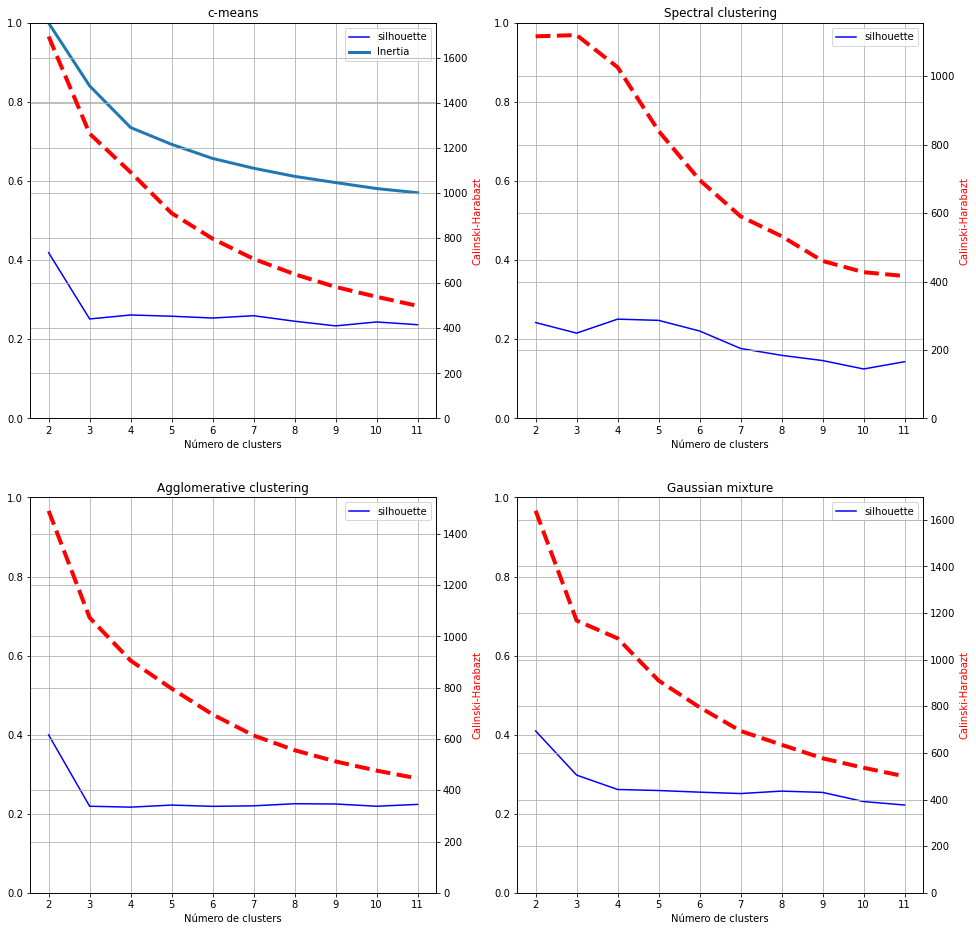

In [6]:
fig = plt.figure(figsize = (16, 16))

############## c-means

ax0 = fig.add_subplot(2, 2, 1)

# entrenamiento y predicción
range_clusters = np.arange(2, 12)
labs_pred = []
inertia = []
for i in range_clusters:
    clusterer = KMeans(n_clusters = i, random_state = seed)
    labs_pred.append(clusterer.fit_predict(X, labs))
    inertia.append(clusterer.inertia_)

# criterios de evaluación
silh_valores = p1.siluetas_test(X = X, y = labs, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 0)
ax = p1.curvas_diagnostico(silh_valores, comparation_true_labels = 0, legend = 0, title = "c-means", ax1 = ax0)
# inercia
inertia = inertia / np.max(inertia)
ax.plot(range_clusters, inertia, label = "Inertia", lw = 3)
ax.legend(loc = "upper right")

############## Spectral clustering

ax1 = fig.add_subplot(2,2,2)

# entrenamiento y predicción
labs_pred = []
for i in range_clusters:
    clusterer = SpectralClustering(n_clusters = i, random_state = seed, affinity = 'nearest_neighbors')
    labs_pred.append(clusterer.fit_predict(X))

# criterios de evaluación
silh_valores = p1.siluetas_test(X = X, y = labs, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 0)
p1.curvas_diagnostico(silh_valores, comparation_true_labels = 0, legend = 1, title = 'Spectral clustering', ax1 = ax1)

############## Agglomerative clustering

ax2 = fig.add_subplot(2, 2, 3)

# entrenamiento y predicción
labs_pred = []
for i in range_clusters:
    clusterer = AgglomerativeClustering(n_clusters = i, distance_threshold = None)
    labs_pred.append(clusterer.fit_predict(X))

# criterios de evaluación
silh_valores = p1.siluetas_test(X = X, y = labs, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 0)
p1.curvas_diagnostico(silh_valores, comparation_true_labels = 0, legend = 1, title = 'Agglomerative clustering', ax1 = ax2)

############## Gaussian mixture

ax3 = fig.add_subplot(2,2,4)

# entrenamiento y predicción
labs_pred = []
for i in range_clusters:
    clusterer = GaussianMixture(n_components = i, random_state = seed)
    labs_pred.append(clusterer.fit_predict(X))

# criterios de evaluación
silh_valores = p1.siluetas_test(X = X, y = labs, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 0)
p1.curvas_diagnostico(silh_valores, comparation_true_labels = 0, legend = 1, title = 'Gaussian mixture', ax1 = ax3)

Atendiendo a los criterios presentados, el mejor clustering sucede para 2 grupos. No obstante, la curva de inercia del algoritmo c-means muestra un 'codo' para 4 *clusters*. De la misma manera, encontramos un pico del índice de silueta en `SpectralClustering`. El resto de curvas muestran también una reducción del decrecimiento a partir 3 y 4 *clusters*. Por tanto, encontramos dos grandes grupos por tanto dentro de nuestro conjunto de datos sin etiquetar además de una estructura más interna de 4 grandes grupos.

La pequeña aparición de este pico de 4 *clusters* y de la reducción del descenso comentado pueden atisbar la presencia de una nueva clase de datos diferente a la del conjunto de datos etiquetados pues esta división no aparecía en el apartado anterior. No obstante, dado que que no se tiene ningún otro conocimiento sobre los datos no podemos realizar ninguna hipótesis más.

## I. II. Clustering para seleccionar los conjuntos de entrenamiento

> Para aplicar algoritmos de aprendizaje supervisado consideraremos el uso de conjuntos de
> entrenamiento de tamaño reducido (p.ej. al 50%) de manera que esta reducción se haga en función de
> alguna estrategia no supervisada dentro de cada clase. Para ello se deberá aplicar algún algoritmo
> de clustering y definir una estrategia para obtener un subconjunto reducido que sea representativo
> de cada clase. Se podrá usar también un conjunto no etiquetado de datos para mejorar, analizar o
> validar (manualmente) algunos de los resultados anteriores.

En este apartado, particionaremos el dataset original en entrenamiento y test atendiendo al criterio
de que ambos ocupen el mayor hipervolumen posible. Esto se consigue de forma aproximada si partimos
el grupo en varios *clusters* y restringimos la elección aleatoria de muestras a un cierto número por
cada cluster, de forma que tratemos de escojer la mitad de puntos de éste. Esto mitiga el riesgo de
conseguir muestras aleatoriamente escogidas que puedan concentrarse más en algunas regiones del
espacio de variables. Nótese que si hacemos un conjunto de entrenamiento al 50% utilizando la
función comúnmente empleada `train_test_split` de `sklearn`, obtenemos una precisión media en los
datos de test alrededor de 0.2, mucho menor que lo que obtendremos con esta técnica. Es por ello,
que necesitamos de mejores conjuntos de entrenamiento.

Lo haremos de la forma siguiente: se consideran 6 grupos, resultado de agrupar el conjunto de
entrenamiento por etiquetas. Dentro de cada grupo i, se realiza un *clustering*. Al obtener las
muestras pertenecientes a cada *cluster*, escogeremos aleatoriamente las muestras en cada *cluster*. No
obstante, el número de elementos que escojamos de cada *cluster* es lo que definirá nuestra
estrategia.

No todos los algoritmos de *clustering* sirven para esta tarea; algoritmos de *clustering* aglomerativo
tienen una tendencia a favorecer *clusters* más grandes, así que no se podría asegurar que entre
*clusters* el tamaño o la cantidad de puntos fueran similares. Por ser el más fácil de analizar y
aportar resultados similares a los otros métodos en el apartado anterior, decidimos utilizar
`KMeans`. Además, comprobamos que el resultado ofrecido por el conjunto de entrenamiento
consecuencia de utilizar `SpectralClustering` en vez de `KMeans` era muy similar. Apenas 0.01 o 0.02
de exactitud media de diferencia en los algoritmos supervisados.

### Estrategia

Procedamos a importar los datos, crear los grupos y realizar los *clusters* correspondientes.
Almacenamos las etiquetas de los *clusters* de cada grupo en un diccionario de manera que podremos
acceder fácilmente más adelante.

Respecto al número de *clusters* de cada grupo, realizaremos un análisis exploratorio para seleccionar el número de
*clusters* óptimo siguiendo las reglas de la sección anterior teniendo en cuenta que obviamente no
conocemos las etiquetas correctas. Sin embargo, no encontramos ningún patrón claro de como dividir
los grupos en subgrupos. Por ello, decidimos dividir todos los grupos en el mismo número de *clusters*
(subgrupos). Tras varias pruebas de enteros desde 4 hasta 25 y comparando los resultados ofrecidos
por los métodos de aprendizaje supervisado con estos conjuntos de entrenamiento, escojimos el número
20. Se adjunta en una figura el análisis de los criterios de *Silhouettes* y Calinski-Harabasz
para los 6 grupos. Resulta necesario que el número mínimo de *clusters* sea un número considerable
como es 4 (y no 2 que es el mínimo) pues sino, esta estrategia no tendría sentido.

Respecto de los parámetros de la función `KMeans` únicamente fijamos la semilla y variamos el número
de *clusters*. Los demás valores son por defecto, al igual que en el apartado anterior.

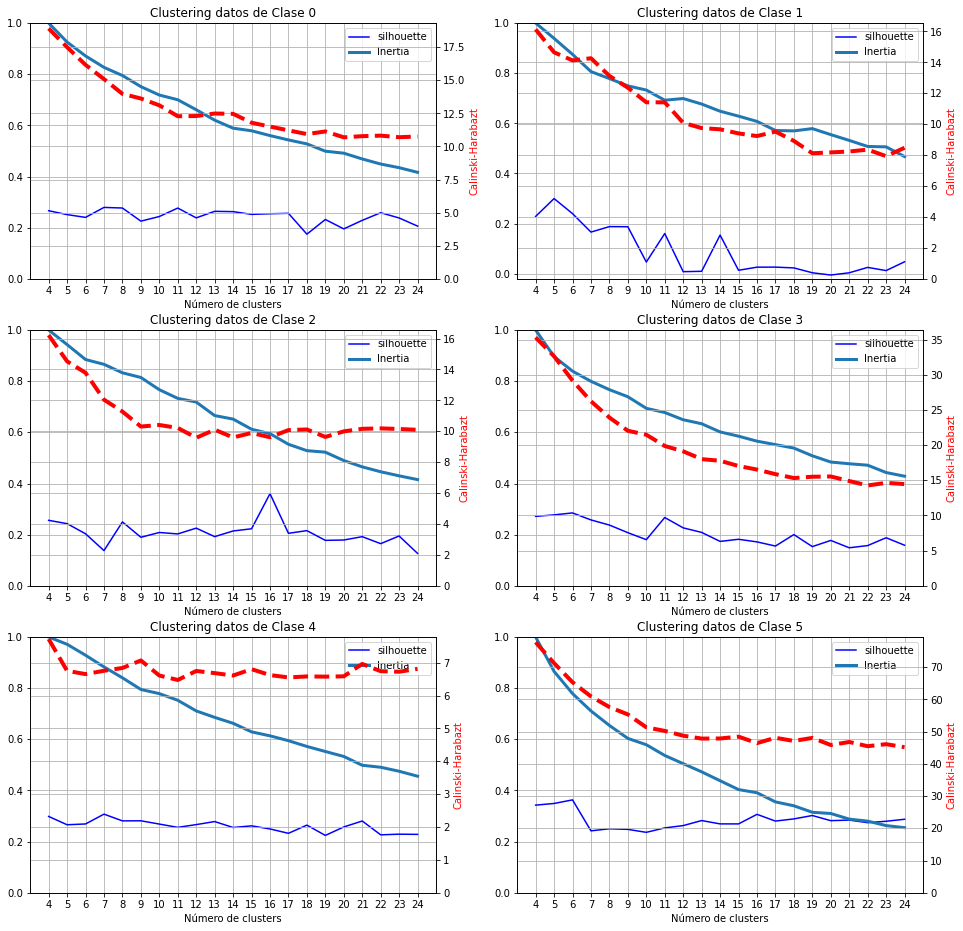

In [7]:
# Importamos los datos
# Los datos ya importados y preprocesados están en la forma que sklearn
# reconoce, es decir, un numpy.ndarray de la forma [muestras, variables]
data, X, labs = p1.importar_y_transformar_datos(n_mfcc = 10, n_mels = 128, n_components = 0.99, verbose = 0)

# Tenemos esta cantidad de muestras,
num_muestras = int(X.shape[0])
# Tenemos seis etiquetas o clases,
num_lab = 6
# Número de clusters a explorar
range_clusters = np.arange(4, 25)

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (16, 16))

for i, ax_ in zip(range(num_lab), np.ravel(ax)):
    # Seleccionamos el grupo de datos de clase i
    X_dict = X[labs == i]
    # Análisis
    labs_pred = []
    inertia = []
    for m in range_clusters:
        clusterer = KMeans(n_clusters = m, random_state = seed, tol = 1e-4)
        labs_pred.append(clusterer.fit_predict(X_dict))
        inertia.append(clusterer.inertia_)
    # resultados
    silh_valores = p1.siluetas_test(X = X_dict, y = None, y_pred = labs_pred, range_n_clusters = range_clusters, comparation_true_labels = 0)
    ax = p1.curvas_diagnostico(silh_valores, comparation_true_labels = 0, legend = 1, title = "Clustering datos de Clase "+str(i), ax1 = ax_)

    # inercia
    inertia = inertia / np.max(inertia)
    ax.plot(range_clusters, inertia, label = "Inertia", lw = 3)
    ax.legend(loc = "upper right")

Ahora sí, creemos nuestro conjunto de entrenamiento. Para ello, utilizaremos una estructura de
diccionario para almacenar los elementos de cada subgrupo j del grupo i. De esta manera, podemos
acceder a ellos de manera intuitiva.

Primero, importemos los datos preprocesados y clasifiquemos las muestras de cada grupo en 20
*clusters*,

In [8]:
data, X, labs = p1.importar_y_transformar_datos(n_mfcc = 10, n_mels = 128, n_components = 0.99, verbose = 0)

# Tenemos esta cantidad de muestras,
num_muestras = int(X.shape[0])
# Tenemos seis etiquetas o clases,
num_lab = 6
# Dentro de cada etiqueta, tendremos veinte clusters
num_clusters = 20

# Creamos un diccionario rellenando cada entrada con el
# subconjunto de los datos que tengan la etiqueta correspondiente a cada llave
# Equivalente a {0:X[labs == 0], 1:X[labs == 1], ..., 5:X[labs == 5]}
# X[labs == i] devuelve un numpy.ndarray también con [muestras, variables] 
X_dict = {i:X[labs == i] for i in range(num_lab)}

# Hacemos un diccionario vacío para guardar las etiquetas
# de los clusters a los que pertenece cada muestra,
labels = {}

# Separamos el dataset en clases
for i in range(num_lab):
    km = KMeans(n_clusters = num_clusters, random_state = 12345)
    # Ajustamos unos n clusters por cada etiqueta,
    km.fit(X_dict[i])
    # El cluster o subgrupo j al que pertenece cada muestra, que va de 0 a 19,
    # se guarda en el grupo i del diccionario previamente vacío labels,
    labels[i] = km.labels_

# Inicializamos un diccionario de diccionarios vacío. Almacenamos los índices de las muestras
# que pertenecen al subgrupo j del grupo i
dictdict = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}, 5:{}}

for i in range(num_lab):
    # Aquí, en cada diccionario vacío en dictdict, representando el grupo i,
    # guardaremos los índices del subgrupo j correspondiente,
    for j in range(num_clusters):
        dictdict[i][j] = np.where(labels[i] == j)[0]

Una vez hayamos establecido qué muestras pertenecen a qué cluster, vamos a seleccionar el 50% de los
datos etiquetados. Es decir, 360. Como los queremos balanceados para cada clase, escogeremos 60
elementos de cada una de las 6 clases. También los querremos balanceados para cada cluster. Cuando
lleguemos a un cluster j, nos preguntaremos cuanto es el número de elementos que contiene. Ante
esto, realizaremos dos acciones:

* Si el número de elementos del cluster es mayor que 1, cogeremos tanto elementos como sea el entero
  resultado de dividir el número de elementos entre 2. Es decir, `veces = num_en_clus//2`.
* Si el número de elementos del cluster es 1, cogeremos ese elemento.

Este proceso se repite hasta llegar a 60 elementos de cada clase. La selección de elementos la
almacenaremos en una estructura de diccionario `index_entr` y  `index_test` para entrenamiento y
test respectivamente. Durante las iteraciones anteriores almacenamos los elementos del conjunto de
entrenamiento de forma que el conjunto de test serán los elementos restantes hasta el total de 720
muestras.

In [9]:
index_entr = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
index_test = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

dict_copy = deepcopy(dictdict)
# Queremos el 50% de los datos etiquetados como conjunto de entrenamiento. La proporción por lo tanto es
prop_entr = 0.5
# Entonces tendremos esta cantidad de muestras de entrenamiento
# por cada etiqueta
elementos_por_clase = int((num_muestras*prop_entr)/num_lab) 

num_mues_entr = 0
for i in range(num_lab): # Por cada etiqueta,
    while len(index_entr[i]) < elementos_por_clase: # y mientras en cada grupo tengamos menos de lo especificado por etiqueta (60)
        for j in range(num_clusters): # y por cada cluster,
            num_en_clus = len(dict_copy[i][j]) # vemos cuántas muestras hay en el cluster j de la etiqueta i.
            ass = 0
            if num_en_clus > 1: # Si hay más de una muestra en el cluster...
                k = 0
                veces = num_en_clus//2 # vemos cuántas 
                while k < veces and len(index_entr[i]) < elementos_por_clase: 
                    ind_mues = np.random.choice(dict_copy[i][j]) # Escogemos elemento (índice) al azar del subgrupo j del grupo i
                    index_entr[i].append(ind_mues) # almacenamos el índice

                    index_deleted = np.where(dict_copy[i][j] == ind_mues)[0] # Ahora vemos donde está dicho índice,
                    dict_copy[i][j] = np.delete(dict_copy[i][j], index_deleted) # y lo eliminamos

                    num_mues_entr = num_mues_entr + 1
                    k = k + 1
            else: # Si solo hay una muestra en el cluster,
                if len(index_entr[i]) < elementos_por_clase:
                    index_entr[i].append(dict_copy[i][j][0]) # Almacenamos esa muestra y au
                    index_deleted = np.where(dict_copy[i][j][0])[0] # Ahora vemos donde está dicho índice,
                    dict_copy[i][j] = np.delete(dict_copy[i][j], index_deleted) # y lo eliminamos

                    num_mues_entr = num_mues_entr + 1

for i in range(num_lab): # Por cada grupo o etiqueta,
    for j in range(num_clusters): # y por cada subgrupo o cluster,
        # Como hemos eliminado las muestras de entrenamiento,
        # sólo nos quedan las de test, así que vamos rellenando el diccionario,
        for k in range(len(dict_copy[i][j])):
            index_test[i].append(dict_copy[i][j][k])

Habiendo obtenido los índices deseados, ahora lo único que hay que hacer es particionar los datos en
sí según estos índices. Crearemos el conjunto de entrenamiento `datos_entr` con sus etiquetas `labs_entr` y el conjunto de test `datos_test` con sus etiquetas `labs_test`.

In [10]:
# Matriz que almacena los datos de entrenamiento
datos_entr = np.zeros((num_mues_entr, X.shape[1]))
# Vector que almacena las etiquetas de entrenamiento
labs_entr = np.zeros(num_mues_entr)
# Matriz que almacena los datos de test
datos_test = np.zeros((X.shape[0] - num_mues_entr, X.shape[1]))
# Vector que almacena las etiquetas de test
labs_test = np.zeros(X.shape[0] - num_mues_entr)

# Aquí rellenamos datos_entr,
sup = 0
inf = 0
for i in range(num_lab):
    ind = index_entr[i] # índices de los elementos seleccionados del grupo i
    l = len(ind)
    sup = sup + l
    datos_entr[inf:(sup), :] = X_dict[i][ind, :] # cogemos las muestras con sus características
    labs_entr[inf:sup] = np.ones((sup - inf))*i # sus etiquetas
    inf = inf + l

# y aquí datos_test,
sup = 0
inf = 0
for i in range(num_lab):
    ind = index_test[i]
    l = len(ind)
    sup = sup + l
    datos_test[inf:(sup), :] = X_dict[i][ind, :]
    labs_test[inf:sup] = np.ones((sup - inf))*i
    inf = inf + l

La forma en que hemos intentado repartir las muestras del conjunto de entrenamiento es algo
aproximada pero hace uso de implementaciones decentemente optimizadas, y podría ser incluso más
rápido si hicieramos uso de técnicas diferentes a las que hemos usado aquí, dado que la manipulación
de listas y los bucles `for` en Python no son de lo más eficientes.

Si tenemos *clusters* conformados por una única muestra, ésta se añade al conjunto de entrenamiento.
Esto puede suponer un problema al tener muchos de estos *clusters*. Únicamente estamos comprobando que
hayan menos muestras que la mitad (60 por clase) y que hayan menos muestras que la mitad del
*cluster*. Con esto controlamos que hayan exactamente la mitad de muestras de entrenamiento pero
pueden haber *clusters* a los que lleguemos y no seleccionar ninguna muestra de entrenamiento.

Dicha situación se puede dar si tenemos una cierta combinación de muestras suficientemente separadas
y una cantidad considerable de *clusters* asignados a cada etiqueta, lo cual hace que potencialmente
hayan muchos *clusters* contando únicamente con una muestra. En principio, es deseable que el uso de
más *clusters* suponga un mayor repartimiento de las muestras de entrenamiento, pero hay que ser
conscientes de la cantidad de *clusters* monomuestra.

De ello se concluye que debemos tener cuidado al usar una técnica como la vista aquí, debido a las
consideraciones anteriormente expuestas, o mejor modificarla substancialmente de acuerdo con un
criterio más refinado.

Siendo conscientes de estos problemas, probamos formas diferentes de seleccionar muestras de
entrenamiento. Sin embargo, la puntuación (evaluada como exactitud media) de los modelos de clasificación resultantes (tanto
supervisados como *ensemble*) fue menor que con estos métodos, por lo tanto, tomamos la decisión de
utilizar el descrito aquí.

Entre ellas, encontramos dos importantes. La primera consistía en ir seleccionando un índice de los
elementos de cada cluster al azar yendo de cluster en cluster hasta que llegamos al límite de
elementos de una determinada clase, repitiendo este proceso para todas las clases. La segunda
consistía en seleccionar el elemento más cercano al centroide del cluster. Dentro de esta segunda
opción diferenciamos dos dependiendo de la definición de distancia escogida: distancia euclídea y
distancia de Mahalanobis.

Por otro lado, encontramos varios artículos en Internet donde se proponía utilizar las etiquetas de
un clustering previo de los datos como una nueva característica con el fin de mejorar la
clasificación. Probamos el caso con 6 etiquetas, pues es el número de clases de nuestro problema,
pero los resultados no mejoraron.

# II. Técnicas de aprendizaje supervisado
## II. I Clasificación mediante algoritmos supervisados
> Utilizar algoritmos supervisados sobre los diferentes conjuntos de entrenamiento para obtener una
> clasificación de los datos. Se debe obtener una estimación del error de clasificación que sea
> suficientemente representativa dados los datos disponibles.

Dividimos este apartado en dos atendiendo a los dos métodos que hemos usado para clasificar; dichos
métodos son los dos clasificadores no lineales principales que hemos visto en la asignatura, el
perceptrón multi-capa y máquina de vector soporte con un kernel gaussiano. Compararemos su bondad a
los datos únicamente mediante la exactitud media (método `.score`), dejando para apartados
posteriores del trabajo otras métricas como la precisión o el *recall*, ya que la exactitud
constituye una métrica suficiente por ahora.

## A. Perceptrón multi-capa

Probemos primero con un perceptrón multi-capa entrenado mediante retropropagación. Recordemos que la
complejidad del problema (~2600 características después de descomponer en MFCCs y ~370 después de
descomponer éstos mediante PCA) es comparable al número de muestras con el que estamos
trabajando (~360), así que debemos tener muy presente el posible sobreajuste. Por lo tanto,
tendremos que utilizar la regularización de la función de coste. Para explorar la bondad del
modelo en función del parámetro de regularización, haremos muchos modelos con valores de $\alpha$
distintos.

Este parámetro es notablemente más importante que otros, tales como la cantidad de capas escondidas
(que suele ser una de todas maneras) así como la cantidad de neuronas en esta capa (basta con que
esté entre el número de variables de entrada y de salida en la mayoría de casos). No obstante,
detallamos los parámetros utilizados:

* 1 capa oculta con 100 neuronas.
* constante de aprendizaje adaptativa de acuerdo con la implementación de `scikit-learn`.

Exactitud media máxima con el conjunto de test: 0.558 para alpha = 788.0


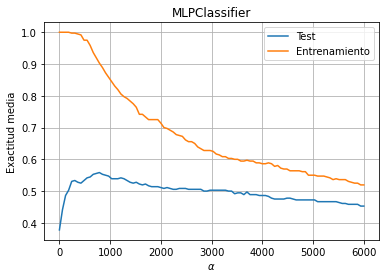

In [11]:
# Hagamos diferentes modelos variando el parámetro de regularización, aquí llamado alpha.
# Inicializamos una lista vacía donde irán los modelos,
models = []
# Así como un vector con los diferentes valores de alpha que usaremos,
alphas = np.linspace(0, 6000, 100)
# Para luego iterar sobre alphas
for i in np.arange(0, len(alphas)):
    # Inicializamos un objeto de la clase MLPClassifier,
    # y lo metemos en models,
    models.append(MLPClassifier(solver = 'adam', hidden_layer_sizes = (100,), alpha = alphas[i], random_state = 123, learning_rate = 'adaptive', tol = 0.1))
    # Entrenamos el modelo pertinente
    models[i].fit(datos_entr, labs_entr)

scores_test = []
scores_model = []
# Obtenemos la bondad de los modelos,
for i in np.arange(0, len(alphas)):
    scores_test.append(models[i].score(datos_test, labs_test))
    scores_model.append(models[i].score(datos_entr, labs_entr))

plt.plot(alphas, scores_test, "-", label = "Test")
plt.plot(alphas, scores_model, "-", label = "Entrenamiento")
plt.title("MLPClassifier")
plt.xlabel(r"$\alpha$")
plt.ylabel("Exactitud media")
plt.grid()
plt.legend()

print("Exactitud media máxima con el conjunto de test:", np.round(np.max(scores_test), 3), "para alpha =", np.round(alphas[np.argmax(scores_test)]))

La puntuación que obtenemos (aquí tomada como la exactitud) es algo pobre; las probabilidades de
predecir la clase de una muestra que no sea de entrenamiento son ligeramente mejores que el de
lanzar una moneda. Además, parece que para el valor de $\alpha$ en que tenemos una puntuación
máxima del conjunto de test, seguimos teniendo lo que parece ser un sobreajuste considerable,
dada la gran diferencia existente entre la exactitud del conjunto de entrenamiento y el de test.

## B. SVM con kernel gaussiano

Ahora veamos qué tal se le da un método de máquina de vector soporte, antes pasando las muestras por
un kernel, en específico con un kernel gaussiano. En lugar de modificar el parámetro de regularización,
lo que haremos es modificar la inversa de la anchura de la gaussiana, aquí llamado $\gamma$.

Exactitud máxima con el conjunto de test de 0.564 para gamma = 1.2000000000000002e-05


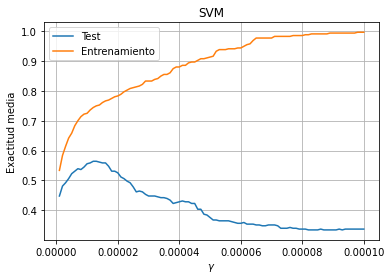

In [12]:
# Ahora haremos diferentes modelos variando la inversa de la anchura de la gaussiana, aquí llamado gamma.
# El procedimiento es idéntico al de la celda de código anterior.
gammas = np.linspace(1e-6, 1e-4, 100) 
models = []
for i in np.arange(0, len(gammas)):
    models.append(SVC(kernel = 'rbf', gamma = gammas[i]))
    models[i].fit(datos_entr, labs_entr)

scores_test = []
scores_model = []
for i in np.arange(0, len(gammas)):
    scores_test.append(models[i].score(datos_test, labs_test))
    scores_model.append(models[i].score(datos_entr, labs_entr))

plt.plot(gammas, scores_test, "-", label = "Test")
plt.plot(gammas, scores_model, "-", label = "Entrenamiento")
plt.title("SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Exactitud media")
plt.legend()
plt.grid()

print("Exactitud máxima con el conjunto de test de", np.round(np.max(scores_test), 3), "para gamma =", gammas[np.argmax(scores_test)])

Podemos observar que hay una ligera mejora en la puntuación máxima del conjunto de test en el caso
de utilizar SVM, sin embargo, es una mejora ínfima. Es cierto que quizás este último método sea
preferible al perceptrón multi-capa dado que la relación de la puntuación entre el entrenamiento y
el test es más cercana a 1 en este punto; esto nos indica que quizá el modelo resultante generalice
mejor que el obtenido con MLP.

# III. Ranking de características y métodos ensemble
## III.I Ranking de características
> Los datos pueden contener atributos con valores erróneos, o que tengan poca relevancia en el
> resultado de la clasificación. Utilizando métodos de clasificación que proporcionen un 'ranking' de
> características, intentar detectar y eliminar aquellas que empeoran (o no mejoran) el resultado de
> la clasificación. De nuevo, dar un resultado cuantitativo del error en test.

Usaremos las clases de `scikit-learn` bajo el módulo `sklearn.feature_selection` para seleccionar
las características más relevantes a este conjunto de muestras. En concreto, en su documentación se
menciona la posibilidad de utilizar un algortimo de clasificación, para luego seleccionar las
características más importantes a través de `sklearn.feature_selection.SelectFromModel`. En nuestro
caso, vamos a usar un algoritmo de SVM lineal y luego usar un algoritmo *random forest*. Examinamos
los resultados de nuestros clasificadores, MLP y SVC con kernel gaussiano, para ambos conjuntos
nuevos. A posteriori y basándonos en estos, evaluaremos cuál de los dos es mejor.

### SVM lineal
Ajustamos un SVM con un kernel lineal a los datos de entrenamiento que tenemos. El *ranking* de cada
característica vendrá dado por los pesos del modelo ajustado resultante. A partir de los pesos
obtenidos, nos deshacemos de una cierta cantidad de características a través de `SelectFromModel` y
de su método `transform`. Esto se hace seleccionando una cota para escoger las características
respecto de dichos pesos. Tomamos aquellas que tienen una importancia mayor que la media. Esta
importancia se caracteriza con un parámetro que no exploraremos en este trabajo. También
probamos con la mediana, pero los resultados eran peores. Esto nos permite reducir el número de
características manteniendo los mismo resultados que sin utilizar esta técnica (el filtrado
`threshold`). 

In [13]:
lsvc = LinearSVC(C = 0.002, penalty = "l1", dual = False).fit(datos_entr, labs_entr)
model = SelectFromModel(lsvc, prefit = True, threshold = 'mean')
datos_entr_menos = model.transform(datos_entr)
datos_test_menos = model.transform(datos_test)
print("Dimensiones originales:", datos_entr.shape[1], ". Dimensiones seleccionadas:", datos_entr_menos.shape[1])

Dimensiones originales: 354 . Dimensiones seleccionadas: 89


Ahora hacemos lo mismo que en el apartado 3 para ajustar muchos modelos con 
$\alpha$ diferente, pero con los datos con características reducidas, primero con `MLPClassifier`.

#### MLPClassifier

Exactitud máxima con el conjunto de test: 0.561 para alpha = 667.0


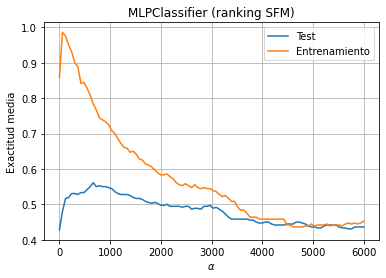

In [14]:
models = []
alphas = np.linspace(0, 6000, 100)
for i in np.arange(0, len(alphas)):
    models.append(MLPClassifier(solver = 'adam', hidden_layer_sizes = (100,), alpha = alphas[i], random_state = 123, learning_rate = 'adaptive', tol = 0.1))
    models[i].fit(datos_entr_menos, labs_entr)

scores_test = []
scores_model = []
for i in np.arange(0, len(alphas)):
    scores_test.append(models[i].score(datos_test_menos, labs_test))
    scores_model.append(models[i].score(datos_entr_menos, labs_entr))

plt.plot(alphas, scores_test, "-", label = "Test")
plt.plot(alphas, scores_model, "-", label = "Entrenamiento")
plt.title("MLPClassifier (ranking SFM)")
plt.xlabel(r"$\alpha$")
plt.ylabel("Exactitud media")
plt.grid()
plt.legend()

print("Exactitud máxima con el conjunto de test:", np.round(np.max(scores_test), 3), "para alpha =", np.round(alphas[np.argmax(scores_test)]))

y ahora lo hacemos cambiando $\gamma$ con el algoritmo de máquina de vector soporte con kernel gaussiano,

#### SVM y un kernel gaussiano

Exactitud máxima con el conjunto de test de 0.567 para gamma = 1.5000000000000002e-05


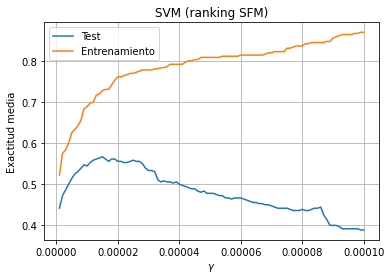

In [15]:
gammas = np.linspace(1e-6, 1e-4, 100) 
models = []
for i in np.arange(0, len(gammas)):
    models.append(SVC(kernel = 'rbf', gamma = gammas[i]))
    models[i].fit(datos_entr_menos, labs_entr)

scores_test = []
scores_model = []
for i in np.arange(0, len(gammas)):
    scores_test.append(models[i].score(datos_test_menos, labs_test))
    scores_model.append(models[i].score(datos_entr_menos, labs_entr))

plt.plot(gammas, scores_test, "-", label = "Test")
plt.plot(gammas, scores_model, "-", label = "Entrenamiento")
plt.title("SVM (ranking SFM)")
plt.xlabel(r"$\gamma$")
plt.ylabel("Exactitud media")
plt.grid()
plt.legend()

print("Exactitud máxima con el conjunto de test de", np.round(np.max(scores_test), 3), "para gamma =", gammas[np.argmax(scores_test)])

Observamos cambios notables en las gráficas de exactitud versus constante de regularización y de
exactitud versus $\gamma$. Uno de ellos es la reducción del rango de valores de cada variable
para la cual la exactitud es 1 en el conjunto de entrenamiento (osea, cuando hay sobreajuste). Podemos destacar que el MLP en particular posee dicha puntuación con un descenso muy acusado, desde un máximo que no retiene, y de hecho, no llega a 1.

Sin embargo, la exactitud máxima del conjunto de test apenas cambia al reducir el número de
características. Sí aumenta, y de hecho la diferencia entre MLP y SVM aumenta, aunque no sabríamos
decir si dicha diferencia es debido a las características de las muestras, o a la naturaleza del
modelo y las muestras.

### Random forest
Procedemos ahora a hacer el *ranking* de características mediante este estimador, para luego
comprobar los resultados obtenidos con los mismos clasificadores de antes. De nuevo, utilizaremos un
filtrado de las dimensiones con el argumento `threshold`. Volvemos a utilizar la media como filtro.

In [16]:
arbol = ExtraTreesClassifier(n_estimators = 50).fit(datos_entr, labs_entr)
modelo_arbol = SelectFromModel(arbol, prefit = True, threshold = 'mean')
data_entr_menos = modelo_arbol.transform(datos_entr)
data_test_menos = modelo_arbol.transform(datos_test)
print("Dimensiones originales:", datos_entr.shape[1], ". Dimensiones seleccionadas: ", datos_entr_menos.shape[1])

Dimensiones originales: 354 . Dimensiones seleccionadas:  89


#### MLPClassifier
Evaluemos los datos en el modelo perceptrón multicapa.

Exactitud máxima con el conjunto de test de 0.561 para alpha = 667.0


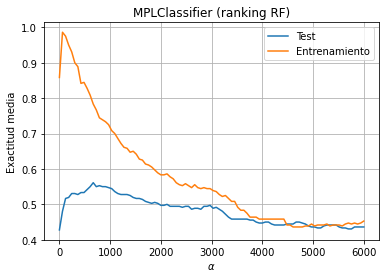

In [17]:
models = []
alphas = np.linspace(0, 6000, 100)
for i in np.arange(0, len(alphas)):
    models.append(MLPClassifier(solver = 'adam', hidden_layer_sizes = (100,), alpha = alphas[i], random_state = 123, learning_rate = 'adaptive', tol = 0.1))
    models[i].fit(datos_entr_menos, labs_entr)

scores_test = []
scores_model = []
for i in np.arange(0, len(alphas)):
    scores_test.append(models[i].score(datos_test_menos, labs_test))
    scores_model.append(models[i].score(datos_entr_menos, labs_entr))

plt.plot(alphas, scores_test, "-", label = "Test")
plt.plot(alphas, scores_model, "-", label = "Entrenamiento")
plt.title("MPLClassifier (ranking RF)")
plt.xlabel(r"$\alpha$")
plt.ylabel("Exactitud media")
plt.grid()
plt.legend()

print("Exactitud máxima con el conjunto de test de", np.round(np.max(scores_test), 3), "para alpha =", np.round(alphas[np.argmax(scores_test)]))

#### SVM y kernel gaussiano
Evaluemos los nuevos datos en este modelo.

Exactitud máxima con el conjunto de test: 0.567 para gamma = 1.5000000000000002e-05


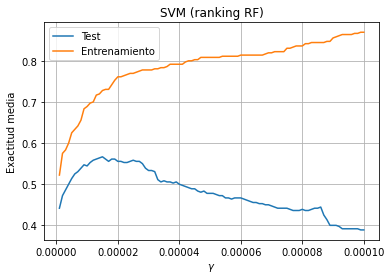

In [18]:
models = []
gammas = np.linspace(1e-6, 1e-4, 100) 
for i in np.arange(0, len(gammas)):
    models.append(SVC(kernel = 'rbf', gamma = gammas[i]))
    models[i].fit(datos_entr_menos, labs_entr)

scores_test = []
scores_model = []
for i in np.arange(0, len(gammas)):
    scores_test.append(models[i].score(datos_test_menos, labs_test))
    scores_model.append(models[i].score(datos_entr_menos, labs_entr))

plt.plot(gammas, scores_test, "-", label = "Test")
plt.plot(gammas, scores_model, "-", label = "Entrenamiento")
plt.title("SVM (ranking RF)")
plt.xlabel(r"$\gamma$")
plt.ylabel("Exactitud media")
plt.grid()
plt.legend()

print("Exactitud máxima con el conjunto de test:", np.round(np.max(scores_test), 3), "para gamma =", gammas[np.argmax(scores_test)])

Parece que obtenemos casi los mismos valores de la exactitud, y obtenemos la misma exactitud máxima.
No existe ningún cambio apreciable al cambiar de método de hacer *ranking* de características.
Sin embargo, probamos a modificar el número de características seleccionadas, y no logramos
modificar mucho la exactitud máxima del conjunto de test. Por lo tanto, la reducción de características ha sido efectiva y hemos conseguido reducir a menos de un tercio el número de atributos de las muestras. Lo cuál implica que teníamos mucho *'ruido'*.

## III.II Métodos ensemble
> Por último, empleando solo el conjunto reducido de muestras etiquetadas (y los atributos
> seleccionados, si procede), utilizar alguna estrategia de combinación de clasificadores (métodos
> *ensemble*) para intentar mejorar los resultados de la clasificación.

Existen multitud de métodos dentro de la categoría *ensemble* pero nosotros utilizaremos los que
aquí se listan. En este apartado, mostraremos los mejores resultados obtenidos para posteriormente
seleccionar el mejor de todos. Para la búsqueda de los valores de los parámetros de cada función
hemos recurrido a la búsqueda manual así como a métodos gráficos como hicimos en las técnicas de
aprendizaje supervisado. Sin embargo, no las incluiremos pues no aportan gran información salvo
mención de su gran dependencia y aletoriedad con la semilla. Dentro de un mal clasificador, el valor
del parámetro y la semilla de número aleatorios juegan un papel fundamental para obtener buenos
resultados. 

Métodos de *ensemble* que utilizaremos:

* *Bagging*
* *Boosting: AdaBoost*
* *Stacked generalization*
* *Random forest*

Más concretamente, emplearemos las implementaciones de la librería `scikit-learn`. Para evaluar los
resultados de cada clasificador utilizaremos las métricas que se describen a continuación. Obtenemos
las métricas con la función `classification_report` también de `scikit-learn`. Recordemos sus
significados:

* *Precision*. De todas las clases que hemos predicho i, cuantas son verdaderamente i. 

*Precision* $= \frac{TP}{TP + FP}$

* *Recall*. Sobre los verdaderos i, cuantos estamos prediciendo bien.

*Recall* $= \frac{TP}{TP + FN}$

* *Accuracy*. De todas las clases i, cuantas hemos predicho correctamente.

* *F1-Score*. Forma de comparar *Precision* y *Recall* a la vez

F1-Score $= \frac{2 \ Precision \ Recall}{Precision + Recall}$

### *Bagging*
Utilizamos 3 clasificadores débiles: `DecisionTreeClassifier`, `GaussianNB` y `SVC` modificando sus
parámetros. El primer clasificador se basa en un árbol de decisión de 4 nodos de profundidad máxima.
Por otro lado, el segundo clasificador es una implementación del algoritmo de *Gaussian Naive Bayes*
al que le seleccionamos un parámetro que obtiene malos resultados también cuando actúa
individualmente. El clasificador `SVC` será con un kernel polinómico de grado 3.  Para ello,
utilizamos los datos transformados del apartado de ranking de características con árbol de decisión.
Probamos con los datos resultado del otro método y los resultados eran muy similares. Eso sí,
siempre mejores que los que obtenemos si utilizamos los datos sin hacer el 'ranking'  de
características. Estos resultados no los incluimos pues no tienen mayor importante. Esto sucederá
también para el resto de métodos.

Para seleccionar la etiquetada de una muestra seleccionamos la clase más votada. Para ello
utilizamos la función `mode` del módulo `scipy.stats`.

In [19]:
# renombrar datos
lsvc = LinearSVC(C = 0.002, penalty = "l1", dual = False).fit(datos_entr, labs_entr)
model = SelectFromModel(lsvc, prefit = True)
datos_entr_menos = model.transform(datos_entr)
datos_test_menos = model.transform(datos_test)

X_train = datos_entr_menos; y_train = labs_entr
X_test = datos_test_menos; y_test = labs_test
# número de modelos para bagging
n_modelos = 200

# parámetros DecisionTreeClassifier
criterion = 'gini'
max_depth = 4

pred_labels = np.zeros((len(y_test), n_modelos))
for i in range(n_modelos):
    # datos
    Xtr, ytr = resample(X_train, y_train, replace = True, random_state = i**3)
    # modelo
    p = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, random_state = seed)
    # entrenamiento
    p.fit(Xtr, ytr)
    # predicción
    pred_labels[:, i] = p.predict(X_test)

pred, votes = mode(pred_labels, axis=1)
print('Bagging DecisionTreeClassifier Res:\n', report(y_test, pred, labels = list(range(6))))

# parámetros GaussianNB
var_smoothing = 0.05

pred_labels = np.zeros((len(y_test),n_modelos))
for i in range(n_modelos):
    # datos
    Xtr, ytr = resample(X_train, y_train, replace = True, random_state = i**4)
    # modelo
    p = GaussianNB(var_smoothing = var_smoothing)
    # entrenamiento
    
    p.fit(Xtr, ytr)
    # predicción
    pred_labels[:, i] = p.predict(X_test)

pred, votes = mode(pred_labels, axis = 1)
print('Bagging GaussianNB Res:\n', report(y_test, pred, labels = list(range(6))))

# parámetros SVC
pred_labels = np.zeros((len(y_test), n_modelos))
for i in range(n_modelos):
    # datos
    Xtr, ytr = resample(X_train, y_train, replace = True, random_state = i**3)
    # modelo
    p = SVC(kernel = 'poly', degree = 3, random_state = seed)
    # entrenamiento
    p.fit(Xtr, ytr)
    # predicción
    pred_labels[:, i] = p.predict(X_test)

pred, votes = mode(pred_labels, axis = 1)
print('Bagging SVC Res:\n', report(y_test, pred, labels = list(range(6))))

Bagging DecisionTreeClassifier Res:
               precision    recall  f1-score   support

           0       0.74      0.33      0.46        60
           1       0.30      0.80      0.44        60
           2       0.38      0.22      0.28        60
           3       0.53      0.33      0.41        60
           4       0.57      0.40      0.47        60
           5       0.83      0.82      0.82        60

    accuracy                           0.48       360
   macro avg       0.56      0.48      0.48       360
weighted avg       0.56      0.48      0.48       360

Bagging GaussianNB Res:
               precision    recall  f1-score   support

           0       0.89      0.13      0.23        60
           1       0.22      0.97      0.36        60
           2       1.00      0.02      0.03        60
           3       0.80      0.20      0.32        60
           4       1.00      0.03      0.06        60
           5       0.72      0.90      0.80        60

    accuracy   

Para seleccionar el mejor modelo queremos que la precisión (*precision*) sea alta y la
sensibilidad (*recall*) también. Por ello, mezclamos dos algoritmos en el bagging de manera que uno
tenga alto *recall* y otro alto *precision*. Este lo conforman `GaussianNB` y `SVC` con kernel
polinómico de grado 3.

In [20]:
pred_labels = np.zeros((len(y_test), int(n_modelos)))
for i in range(int(n_modelos/2)):
    # datos
    Xtr, ytr = resample(X_train, y_train, replace = True, random_state = i**4)
    # modelo
    p = GaussianNB(var_smoothing = var_smoothing)
    # entrenamiento
    p.fit(Xtr,ytr)
    # predicción
    pred_labels[:,i] = p.predict(X_test)

for i in range(int(n_modelos/2),n_modelos):
    # datos
    Xtr, ytr = resample(X_train, y_train, replace = True, random_state = i**3)
    # modelo
    p = SVC(kernel = 'poly', degree = 3, random_state = seed)
    # entrenamiento
    p.fit(Xtr,ytr)
    # predicción
    pred_labels[:,i] = p.predict(X_test)

pred, votes = mode(pred_labels, axis = 1)
print('Bagging SVC Res:\n', report(y_test, pred, labels = list(range(6))))

Bagging SVC Res:
               precision    recall  f1-score   support

           0       0.78      0.12      0.20        60
           1       0.22      0.97      0.36        60
           2       1.00      0.02      0.03        60
           3       1.00      0.22      0.36        60
           4       1.00      0.05      0.10        60
           5       0.76      0.88      0.82        60

    accuracy                           0.38       360
   macro avg       0.79      0.38      0.31       360
weighted avg       0.79      0.38      0.31       360



### AdaBoost
Realicemos un AdaBoost mediante los estimadores anteriores `DecisionTreeClassifier` y `GaussianNB`.
Para ello, utilizaremos la implementación de `scikit-learn` `AdaBoostClassifier` del
módulo `sklearn.ensemble`. Buscamos los mejores valores de los parámetros `criterion` y `max_depth`
para el árbol de decisión y `var_smoothing` para el otro clasificador. 

* Para el árbol de decisión: la profundidad máxima `max_depth` es 3 nodos y el criterio para
  construir el árbol es la impureza de Gini.
* Para `GaussianNB`, utilizamos un parámetro ligeramente inferior que en el *bagging*.

In [21]:
# Árbol de decisión
clasif = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = 'gini', max_depth = 3), n_estimators = n_modelos, random_state = seed)
clasif.fit(X_train, y_train)
preds = clasif.predict(X_test)
print('AdaBoost DecisionTreeClassifier Res:\n', report(y_test, preds, labels = list(range(6)))) 
# GaussianNB
clasif = AdaBoostClassifier(base_estimator = GaussianNB(var_smoothing = 85e-5), n_estimators = n_modelos, random_state = seed)
clasif.fit(X_train, y_train)
preds = clasif.predict(X_test)
print('AdaBoost GaussianNB Res:\n', report(y_test, preds, labels = list(range(6))))

AdaBoost DecisionTreeClassifier Res:
               precision    recall  f1-score   support

           0       0.42      0.32      0.36        60
           1       0.40      0.82      0.54        60
           2       0.33      0.55      0.41        60
           3       0.65      0.40      0.49        60
           4       0.87      0.22      0.35        60
           5       0.98      0.68      0.80        60

    accuracy                           0.50       360
   macro avg       0.61      0.50      0.49       360
weighted avg       0.61      0.50      0.49       360

AdaBoost GaussianNB Res:
               precision    recall  f1-score   support

           0       0.64      0.53      0.58        60
           1       0.34      0.67      0.45        60
           2       0.30      0.30      0.30        60
           3       0.72      0.57      0.64        60
           4       0.65      0.33      0.44        60
           5       0.93      0.85      0.89        60

    accuracy 

### Random Forest

Fijamos la semilla y tomamos la máxima profundidad a 6 nodos, además de utilizar el criterio de entropía de Shannon.

In [22]:
clasif = RandomForestClassifier(n_estimators = n_modelos, criterion = 'entropy', max_depth = 6, random_state = seed)
clasif.fit(X_train, y_train)
preds = clasif.predict(X_test)
print('AdaBoost DecisionTreeClassifier Res:\n', report(y_test, preds, labels = list(range(6))))

AdaBoost DecisionTreeClassifier Res:
               precision    recall  f1-score   support

           0       0.62      0.43      0.51        60
           1       0.36      0.72      0.48        60
           2       0.52      0.28      0.37        60
           3       0.50      0.47      0.48        60
           4       0.71      0.42      0.53        60
           5       0.76      0.95      0.84        60

    accuracy                           0.54       360
   macro avg       0.58      0.54      0.53       360
weighted avg       0.58      0.54      0.53       360



### Stacked Generalization
Utilizamos como primer estimador un árbol de decisión, como segundo un algoritmo de *Gaussian Naive
Bayes* y un clasificador lineal que utiliza la estadística Bayesiana para ajustar las densidades de
cada clase (`LinearDiscriminantAnalysis`). Seleccionamos los parámetros adecuados para obtener un
buen resultado. Como segundo estimador utilizamos una regresión logística implementada en
`scikit-learn`.

In [23]:
estimators = [('dtc',DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state = seed)),
              ('GNB',GaussianNB()),
              ('lda',LinearDiscriminantAnalysis())]
          
clasif = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

clasif.fit(X_train, y_train)
preds = clasif.predict(X_test)
print('AdaBoost DecisionTreeClassifier Res:\n', report(y_test, preds, labels = list(range(6))))

AdaBoost DecisionTreeClassifier Res:
               precision    recall  f1-score   support

           0       0.60      0.42      0.49        60
           1       0.32      0.13      0.19        60
           2       0.25      0.58      0.35        60
           3       0.50      0.45      0.47        60
           4       0.61      0.38      0.47        60
           5       0.84      0.88      0.86        60

    accuracy                           0.48       360
   macro avg       0.52      0.47      0.47       360
weighted avg       0.52      0.47      0.47       360



# IV. Conclusiones
### Métricas del mejor modelo
Atendiendo tanto a la precisión como al *recall* y priorizando la precisión, el método que
proporciona mejores resultados es el *Bagging* de `SVC`. Obtenemos una precisión media de 0.86 y un
*recall* de 0.37. Si hubiésemos querido mantener las dos métricas lo más grandes posible, deberíamos
haber seleccionado el método AdaBoost con el algoritmo gaussiano de Naive-Bayes que ofrece una
precisión de 0.62 y un *recall* de 0.57.

### Distribución de las predicciones
Utilicemos el mejor modelo (*Bagging* de SVC) para predecir las clases de los datos no etiquetados.
Para ello, necesitaremos importar y transformar los datos con cuidado. 

Anteriormente, transformábamos los datos mediante PCA seleccionando aquellas componentes que
explicaban un 99% de la varianza de los datos. Esto proporcionaba un número de características
diferente para cada conjunto de datos que introducíamos pues la varianza de 10 datos no es igual que
la de 1000. Por otro lado, los métodos implementados en `scikit-learn` para la selección de
características permiten transformar datos (método `transform`) que tengan el mismo número de
atributos que el conjunto de datos con el que se ha entrenado (método `fit`). Por tanto, al realizar
la transformación del conjunto de datos no etiquetado debe devolvernos una matriz con un número de
columnas idéntico al número de columnas de la matriz de datos con las que se entrenó el modelo de
selección de características. De lo contrario, no podemos seleccionar las características adecuadas.

Para resolver este inconveniente, se ha implementado la función
`importar_y_transformar_datos_no_etiquetados` en el archivo `punto1.py`. Además, debemos definir un
nuevo objeto, `modelo_arbol` con un máximo de características igual al número de columnas del
conjunto de datos con las características ya seleccionadas (`datos_entr_menos`).

In [24]:
# Importamos y transformamos los datos
data, X = p1.importar_y_transformar_datos_no_etiquetados(n_mfcc = 10, n_mels = 128, n_components = datos_entr.shape[1], verbose = 0)
# Ranking de características
modelo_arbol = SelectFromModel(arbol, prefit = True, max_features = datos_entr_menos.shape[1])
X_menos = modelo_arbol.transform(X)

# Parámetros SVC
pred_labels = np.zeros((X_menos.shape[0], n_modelos))
for i in range(n_modelos):
    # Datos
    Xtr, ytr = resample(X_train, y_train, replace = True)
    # Modelo
    p = SVC(kernel = 'poly', degree = 3, random_state = seed)
    # Entrenamiento
    p.fit(Xtr, ytr)
    # Predicción
    pred_labels[:, i] = p.predict(X_menos)

pred, votes = mode(pred_labels, axis = 1)

Para poder analizar los resultados de la clasificación establecemos un criterio diferente a la moda
para clasificar una muestra. Consideraremos como clasificadas a una clase *i* aquellas muestras cuyo
número de votos sea mayor que una determinada cantidad. Decidimos además que esta cantidad es un
determinado porcentaje del máximo de votos posible, es decir, `% n_modelos`.

Muestras clasificadas por clase:  [12, 1024, 10, 109, 192, 559] . Muestras sin clasificar para 50.0 % de votos : 94
Muestras clasificadas por clase:  [9, 519, 7, 93, 124, 546] . Muestras sin clasificar para 60.0 % de votos : 702
Muestras clasificadas por clase:  [6, 131, 4, 73, 89, 525] . Muestras sin clasificar para 70.0 % de votos : 1172
Muestras clasificadas por clase:  [4, 6, 3, 53, 57, 510] . Muestras sin clasificar para 80.0 % de votos : 1367
Muestras clasificadas por clase:  [4, 0, 1, 36, 26, 488] . Muestras sin clasificar para 90.0 % de votos : 1445
Muestras clasificadas por clase:  [4, 0, 1, 28, 10, 460] . Muestras sin clasificar para 95.0 % de votos : 1497


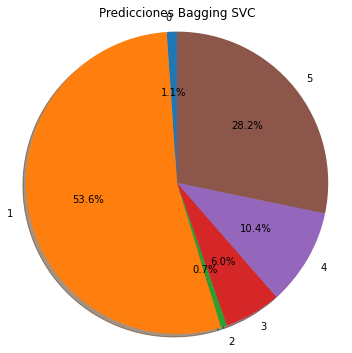

In [25]:
for perc in (0.5, 0.6, 0.7, 0.8, 0.9, 0.95):
    preds = []
    for i in range(6):
        x = 0
        selecc = votes[pred == i]
        for m in selecc:
            if m > n_modelos*perc:
                x += 1
        preds.append(x)

    print("Muestras clasificadas por clase: ", preds, ". Muestras sin clasificar para", perc*100, "% de votos :", X.shape[0] - np.sum(preds))

z = []
for i in range(6):
    e = 0
    for v in votes[pred == i]:
        e = e + 1
    z.append(e)

fig1, ax1 = plt.subplots(figsize = (5, 5))
ax1.pie(z, labels = list(range(6)), autopct = '%1.1f%%', shadow = True, startangle = 90)
# Una relación de aspecto igual asegura que el gráfico se dibuja como un círculo
ax1.axis('equal')
ax1.set_title('Predicciones Bagging SVC')
fig1.tight_layout()
plt.show()

Siguiendo este criterio, encontramos 94 muestras no clasificadas para un 80% de los votos.
Encontramos una mayoría de muestras pertenecientes a la clase 1 (1024) (click de un ratón) cuando
seleccionamos por un 50% de los votos como criterio. Sin embargo, cuando somos más estrictos y
seleccionamos por un 95% de los votos encontramos que la clase mayoritaria (460) es la 5
*washing machine* (lavadora). Cabe recordar que estas clase era las que mayor *recall* en los datos de
test de los métodos *ensemble*. Además, fue *washing machine* la clase que más claramente se
diferenciaba de las otras como vimos en las técnicas de aprendizaje no supervisado. 

Por tanto, parecen existir varias clases diferentes a las del entrenamiento. ¿Por qué? Por un lado,
una clase o más se agrupan en la clase *washing machine* (clase 5). Esto explicaría que al 95% de
votación esta clase fuese la mayoritaria con 460 muestras y más del 50% de las etiquetadas. Por otro
lado, también podrían existir una o más clases similares al click de un ratón (clase 1) aunque con
menos seguridad pues esta amplia mayoría se da con el 50% de los votos.

Para concluir, hemos de destacar que los resultados obtenidos se podrían mejorar realizando
un análisis exploratorio de los datos algo más exhaustivo, dado que en este trabajo hemos hecho
hincapié en los pasos siguientes del procesado de los datos.